# Train language model

In [1]:
from fastai.text import *

In [2]:
path = Path('./')
# path = Path('/home/tony/Documents/jigsaw-unintended-bias-in-toxicity-classification')

# Initializing language model data

### Load csv

In [6]:
train_df = pd.read_csv(path/'train.csv')

In [7]:
# valid_df = pd.read_csv(path/'test.csv')

### Look at the data

In [8]:
train_df

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804869,6333967,0.000000,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399385,approved,0,0,0,0,0,0.0,0,4
1804870,6333969,0.000000,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399528,approved,0,0,0,0,0,0.0,0,4
1804871,6333982,0.000000,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399457,approved,0,0,0,0,0,0.0,0,4
1804872,6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,...,399519,approved,0,0,0,0,0,0.0,0,66


In [9]:
train_df.target = train_df.target.apply(lambda x : 0 if x < 0.5 else 1)

In [10]:
train_df.to_csv(path/'train_class.csv')

### Using data bunch

In [11]:
# data_lm = TextDataBunch.from_df(path, train_df, valid_df, text_cols='comment_text')
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', text_cols='comment_text')

In [12]:
data_lm.save(path/'language_model.pkl')

# Prepare to train language model

## Setup model

In [5]:
bs=16

In [6]:
data_lm = load_data(path, 'language_model.pkl', bs=bs)

### AWD_LSTM

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.15)

### Transformer

In [ ]:
learn = language_model_learner(data_lm, Transformer, drop_mult=0.3).to_fp16()

### TransformerXL

In [15]:
learn = language_model_learner(data_lm, TransformerXL, drop_mult=0.1)

/home/tony/anaconda3/envs/ml/lib/python3.7/site-packages/fastai/text/learner.py:215: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


# Load and save language model

In [15]:
learn = learn.load('awd')

In [20]:
learn.save('awd')

In [21]:
learn.save_encoder('awd_enc')

# Finding learning rate

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


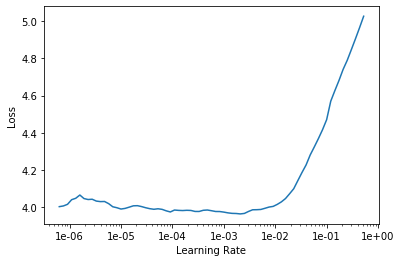

In [18]:
learn.recorder.plot(skip_end=15)

# Train language model

In [16]:
learn.unfreeze()

In [ ]:
learn.freeze_to(-3)

In [19]:
learn.fit_one_cycle(4, 1e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.953303,3.957725,0.320945,3:05:16
1,3.917319,3.957561,0.320961,3:42:35
2,3.941878,3.957314,0.321001,4:41:26


KeyboardInterrupt: 

# Prepare classification dataset

In [10]:
data_class = (TextList.from_csv(path, 'train_class.csv', vocab=data_lm.train_ds.vocab, cols='comment_text')
           .split_by_rand_pct(0.1)
           .label_from_df(cols='target', label_cls=CategoryList)
           .databunch())

In [11]:
data_class.save(path/'data_class.pkl')

# Load classification dataset

In [3]:
bs=10

In [4]:
data_class = load_data(path, 'data_class.pkl', bs=bs, num_workers=2)

# Prepare classification model

### AWD_LSTM

In [5]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.25)

### TransformerXL

In [5]:
learn = text_classifier_learner(data_class, TransformerXL, drop_mult=0.35).to_fp16()

/home/tony/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/text/learner.py:297: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


### Half/Full Precision

In [6]:
learn = learn.to_fp16()

In [ ]:
learn = learn.to_fp32()

# Load and save model

In [7]:
learn.load_encoder('awd_enc');

In [6]:
learn = learn.load('awd_class')

In [9]:
learn.save('awd_class')

# Find learning rate

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


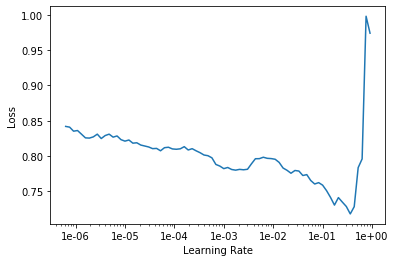

In [14]:
learn.recorder.plot()

# Train regression model

In [7]:
learn.unfreeze()

In [8]:
learn.freeze_to(-4)

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(4, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


# Export

In [12]:
learn.export('text_toxicity.pkl')